In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pylab import rcParams
# from sklearn.model_selection import GridSearchCV, train_test_split


warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(15, 7)})
sns.set_style('white')
pd.set_option('display.max_columns', 500)

###### Time Series Analysis

In [68]:
neighborhoods = ['SWISU', 'Edwards', 'IDOTRR', 'OldTown', 'NWAmes', 'Blmngtn',
                 'Mitchel', 'NridgHt', 'NAmes', 'CollgCr', 'SawyerW', 'MeadowV',
                 'BrDale', 'Gilbert', 'Timber', 'Somerst', 'BrkSide', 'NoRidge',
                 'Sawyer', 'Crawfor', 'Greens', 'ClearCr', 'GrnHill', 'StoneBr',
                 'Veenker', 'NPkVill', 'Blueste', 'Landmrk']

In [308]:
neighborhood = 'SWISU'
housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
housing = housing[housing['Neighborhood'] == neighborhood]
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')

df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
df.rename(columns={'SalePrice': 'Observed'}, inplace=True)

adf = sm.tsa.adfuller(df)
print(f'adf test: {adf[0]}, p-value: {adf[1]}')

# pval is kinda high, so we need to difference first

adf test: -3.7592383129809224, p-value: 0.0033530035245061627


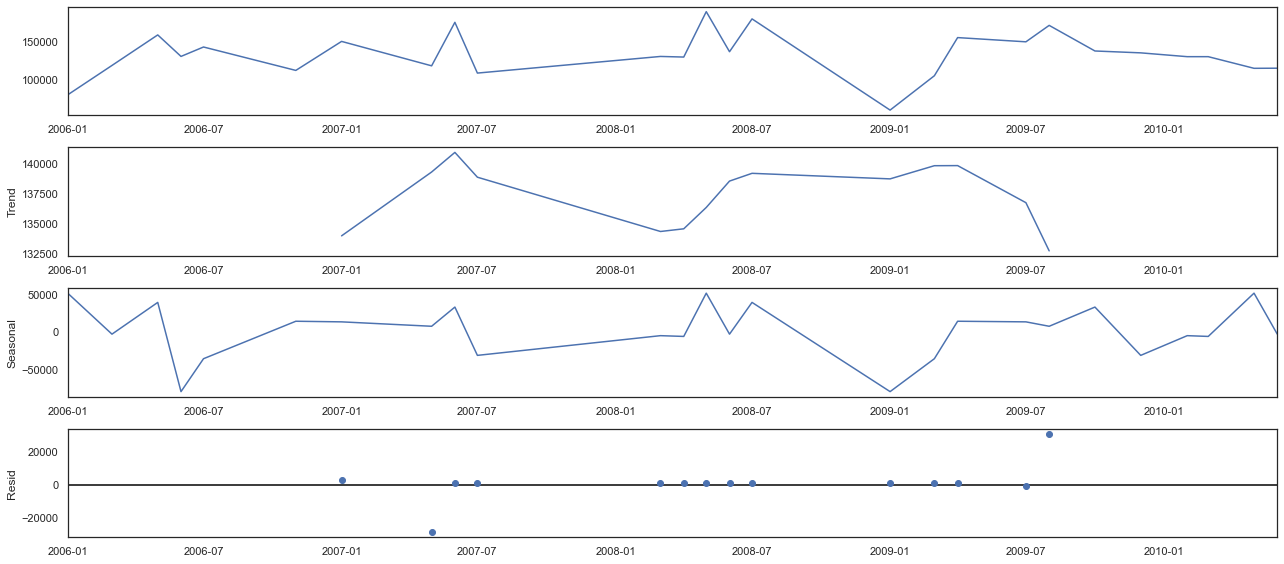

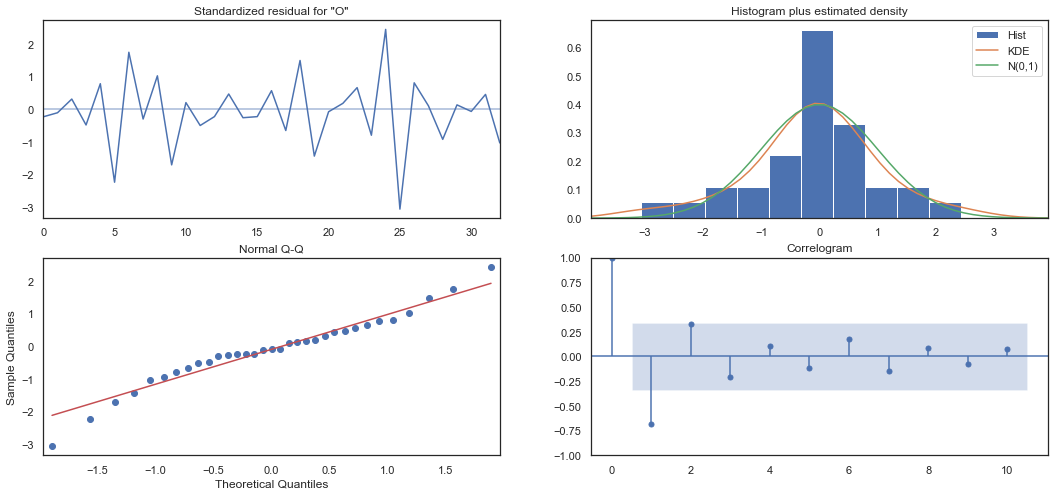

In [309]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=12)
fig = decomposition.plot()
plt.show()

result.plot_diagnostics()
plt.show()

In [310]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[4]}')

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [311]:
results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            result = mod.fit(disp=False)
            results.append([param, param_seasonal, result.aic])
            
        except:
            continue
            
# lets find the best parameters with the lowest AIC score and lowest MSE
optimal_sarima = 1e6
optimal_pdq = []
optimal_spdq = []

for arima, sarima, aic in results:
    if aic < optimal_sarima:
        optimal_sarima = aic
        optimal_pdq = arima
        optimal_spdq = sarima
    else:
        continue
        
print(f'arima: {optimal_pdq}, sarima: {optimal_spdq}, AIC: {optimal_sarima}')
print(f'[{optimal_pdq}, {optimal_spdq}, True, True]')

arima: (1, 1, 0), sarima: (0, 1, 1, 12), AIC: 322.97226981782813
[(1, 1, 0), (0, 1, 1, 12), True, True]


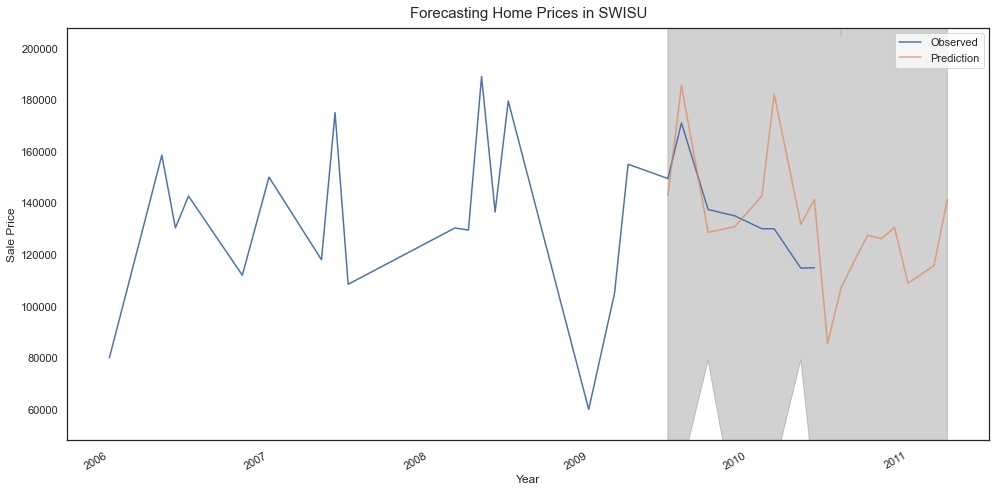

In [312]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=optimal_pdq,
                                seasonal_order=optimal_spdq,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
result = mod.fit(disp=False)

predict = result.get_prediction(start=pd.to_datetime('2009-07-01'), dynamic=False)
forecast = result.get_forecast(steps=10)

forecast_dates = pd.date_range(predict.predicted_mean.index[len(predict.predicted_mean)-1], 
                  freq='MS', periods=len(forecast.predicted_mean)).shift(1)

ci = predict.conf_int().append(forecast.conf_int().set_axis(forecast_dates))
pred = predict.predicted_mean.append(forecast.predicted_mean.set_axis(forecast_dates))
fig = df.plot(label='Observed')

predicted_mean = pred.shift(-1)
predicted_mean.iloc[len(predicted_mean)-1] = result.forecast(1)
predicted_mean.plot(ax=fig, label='Prediction', alpha=.7, figsize=(14, 7))

fig.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k', alpha=.2)

fig.set(xlabel = 'Year', ylabel = 'Sale Price',
         ylim = (min(df['Observed']) - 0.2*min(df['Observed']), 
                 max(df['Observed']) + 0.1*max(df['Observed'])))

plt.title(f'Forecasting Home Prices in {neighborhood}', fontsize = 15, pad=10)
plt.legend()
plt.tight_layout()
plt.savefig(f'./visualizations/{neighborhood}_sarima_prediction.png', dpi = 600)
plt.show()

In [270]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=optimal_pdq,
                                seasonal_order=optimal_spdq,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
result = mod.fit(disp=False)
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6563      0.319     -2.056      0.040      -1.282      -0.031
ma.S.L12      -0.6249      0.908     -0.688      0.491      -2.404       1.155
sigma2      2.168e+10   1.59e-11   1.36e+21      0.000    2.17e+10    2.17e+10


In [305]:
neighborhood_params = {
    'SWISU': [(1, 1, 1), (1, 0, 1, 4), True, True, '2009-07-01',
             [6e4, 8e4, 1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5, 2e5],
             ['60K', '80K', '100K', '120K', '140K', '160K', '180K', '200K']],
    'Edwards': [(0, 1, 0), (1, 1, 1, 8), True, True, '2009-07-01',
               [5e4, 1e5, 1.5e5, 2e5, 2.5e5, 3e5],
               ['50K', '100K', '150K', '200K', '250K', '300K']],
    'IDOTRR': [(1, 0, 0), (1, 0, 1, 10), True, True, '2009-07-01',
              [5e4, 7.5e4, 1e5, 1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5],
              ['50K', '75K', '100K', '125K', '150K', '175K', '200K', '225K']],
    'OldTown': [(1, 1, 0), (1, 0, 1, 8), True, True, '2009-07-01',
               [8e4, 1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5],
               ['80K', '100K', '120K', '140K', '160K', '180K']],
    'NWAmes': [(1, 1, 0), (1, 0, 0, 10), True, False, '2009-07-01',
              [1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5, 2.75e5, 3e5],
              ['125K', '150K', '175K', '200K', '225K', '250K', '275K', '300K']],
    'Blmngtn': [], #none
    'Mitchel': [(1, 0, 0), (0, 0, 1, 10), True, True, '2009-07-01',
                [1e5, 1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5], 
                ['100K', '125K', '150K', '175K', '200K', '225K', '250K']],
    'NridgHt': [(1, 0, 0), (1, 0, 1, 11), True, False, '2009-07-01',
               [2e5, 2.5e5, 3e5, 3.5e5, 4e5, 4.5e5],
               ['200K', '250K', '300K', '350K', '400K', '450K']],
    'NAmes': [(0, 1, 0), (1, 1, 0, 12), False, False, '2009-07-01',
             [1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5],
             ['100K', '120K', '140K', '160K', '180K']],
    'CollgCr': [(0, 1, 1), (0, 1, 1, 12), True, True, '2009-07-01',
               [1.25e5, 1.75e5, 2.25e5, 2.75e5, 3.25e5],
               ['125K', '175K', '225K', '275K', '325K']],
    'SawyerW': [(0, 1, 0), (0, 1, 0, 8), True, True, '2009-07-01',
               [1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5, 2.75e5],
               ['125K', '150K', '175K', '200K', '225K', '250K', '275K']],
    'MeadowV': [(), (), True, True], #none
    'BrDale': [(), (), True, True], #none
    'Gilbert': [(0, 1, 0), (0, 1, 1, 10), True, True, '2009-07-01',
               [1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5, 2.75e5, 3e5],
               ['125K', '150K', '175K', '200K', '225K', '250K', '275K', '300K']],
    'Timber': [(1, 1, 0), (1, 0, 1, 12), True, True, '2009-07-01',
              [1.5e5, 2e5, 2.5e5, 3e5, 3.5e5, 4e5, 4.5e5],
              ['150K', '200K', '250K', '300K', '350K', '400K', '450K']],
    'Somerst': [(0, 1, 0), (0, 0, 1, 10), True, True, '2009-07-01',
               [1.5e5, 2e5, 2.5e5, 3e5, 3.5e5, 4e5, 4.5e5],
               ['150K', '200K', '250K', '300K', '350K', '400K', '450K']],
    'BrkSide': [(0, 1, 0), (1, 0, 1, 12), False, True, '2009-07-01',
               [4e4, 6e4, 8e4, 1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5],
               ['40K', '60K', '80K', '100K', '120K', '140K', '160K', '180K']],
    'NoRidge': [(1, 1, 0), (1, 0, 0, 11), False, True, '2009-07-01',
               [2.5e5, 3e5, 3.5e5, 4e5, 4.5e5, 5e5, 5.5e5, 6e5],
               ['250K', '300K', '350K', '400K', '450K', '500K', '550K', '600K']],
    'Sawyer': [(0, 1, 1), (0, 0, 1, 8), True, False, '2009-07-01',
              [6e4, 8e4, 1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5, 2e5],
              ['60K', '80K', '100K', '120K', '140K', '160K', '180K', '200K']],
    'Crawfor': [(0, 1, 0), (0, 0, 1, 9), True, True, '2009-07-01',
               [1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5, 2.75e5, 3e5, 3.25e5],
               ['125K', '150K', '175K', '200K', '225K', '250K', '275K', '300K', '325K']],
    'Greens': [(), (), True, True], #none
    'ClearCr': [(0, 1, 0), (0, 0, 1, 10), False, False, '2009-06-01',
               [1e5, 1.5e5, 2e5, 2.5e5, 3e5],
               ['100K', '150K', '200K', '250K', '300K']],
    'GrnHill': [(), (), True, True], #none
    'StoneBr': [(0, 1, 0), (0, 0, 1, 9), True, False, '2009-07-01',
               [2e5, 3e5, 4e5, 5e5, 6e5],
               ['200K', '300K','400K', '500K', '600K']],
    'Veenker': [(), (), True, True], #none
    'NPkVill': [(), (), True, True], #none
    'Blueste': [(), (), True, True], #none
    'Landmrk': [(), (), True, True] #none
    
}

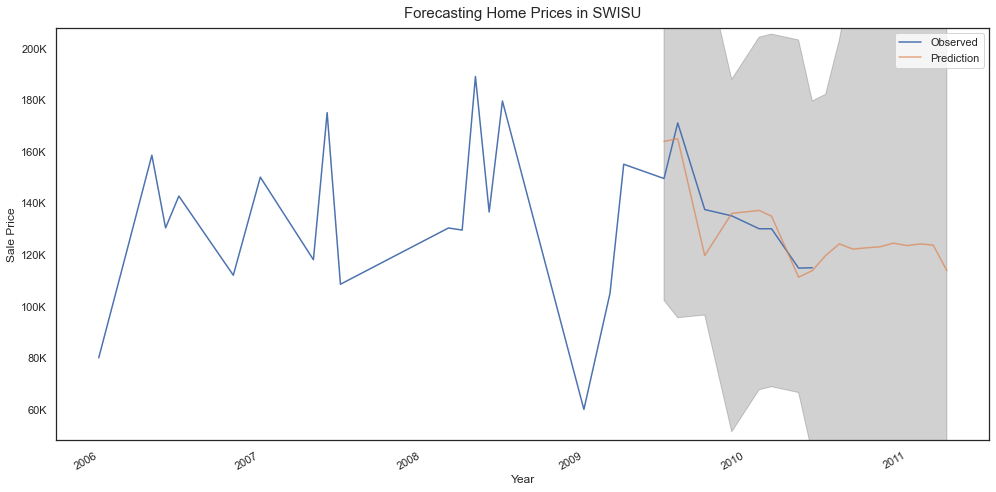

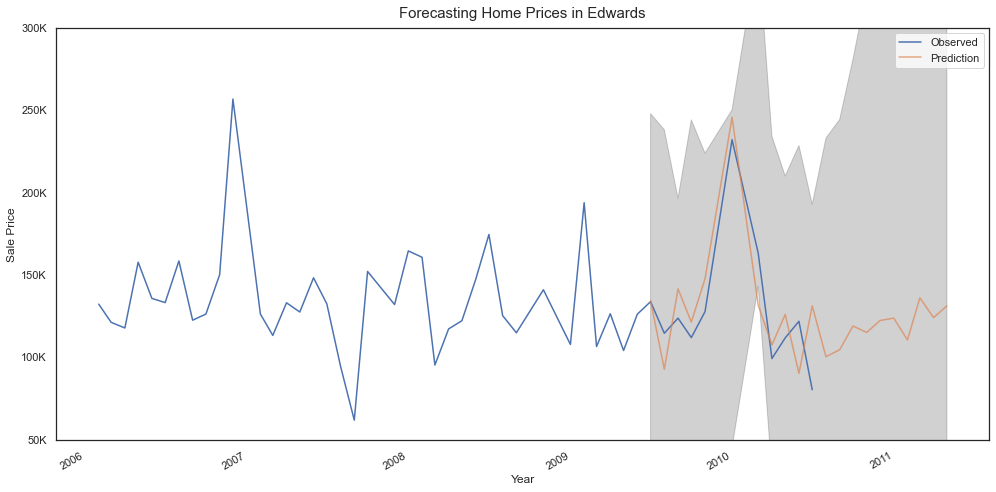

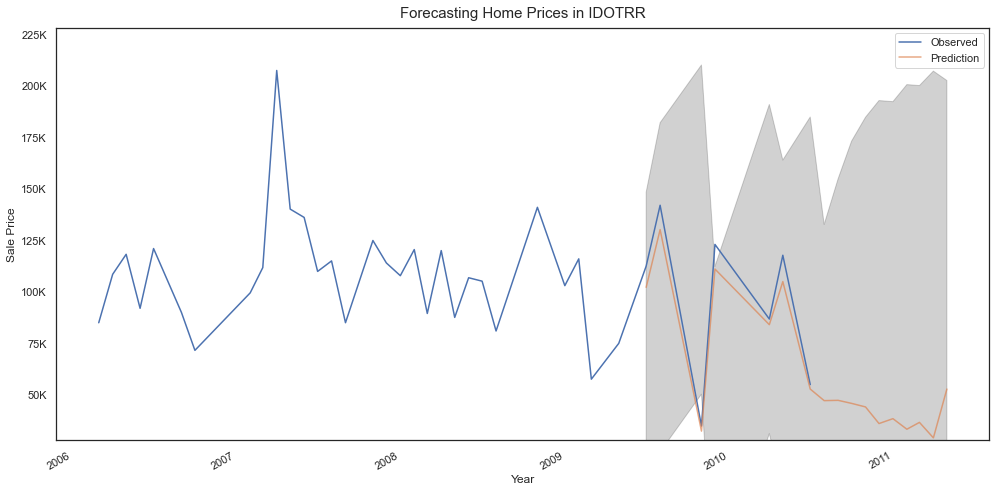

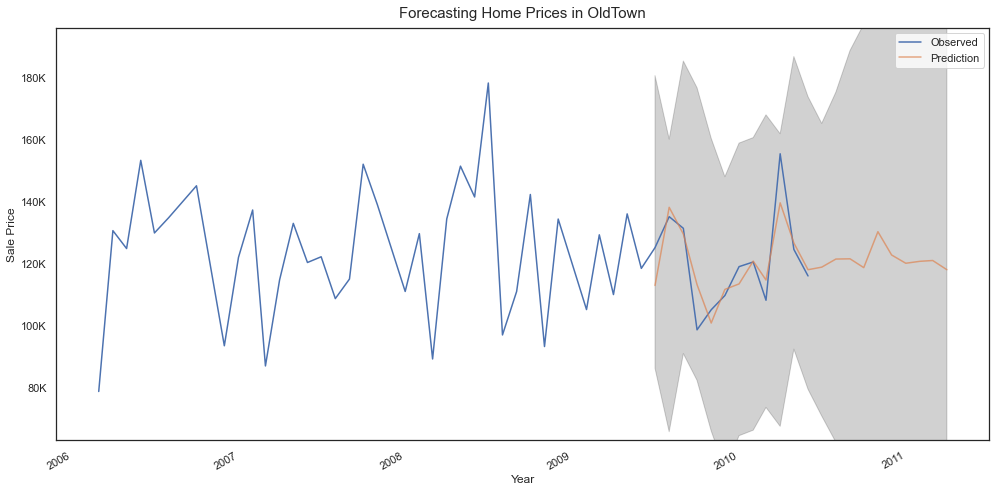

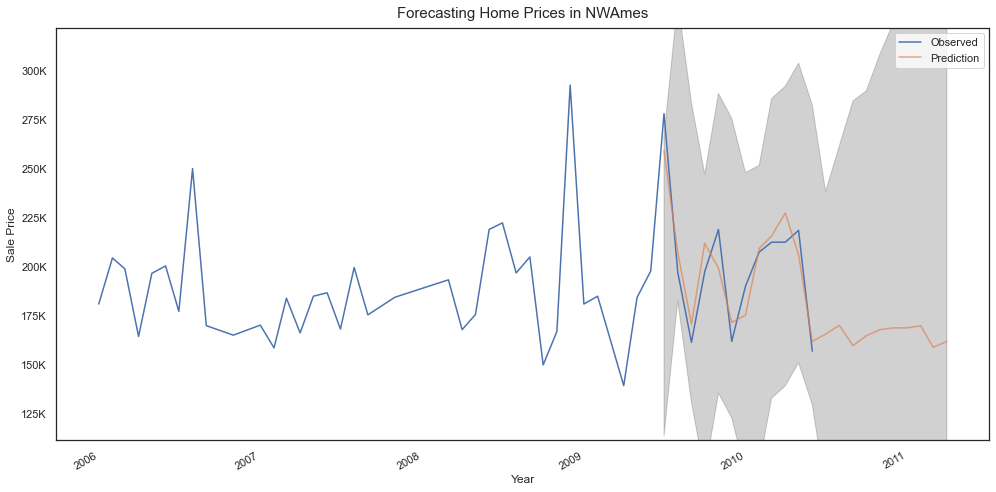

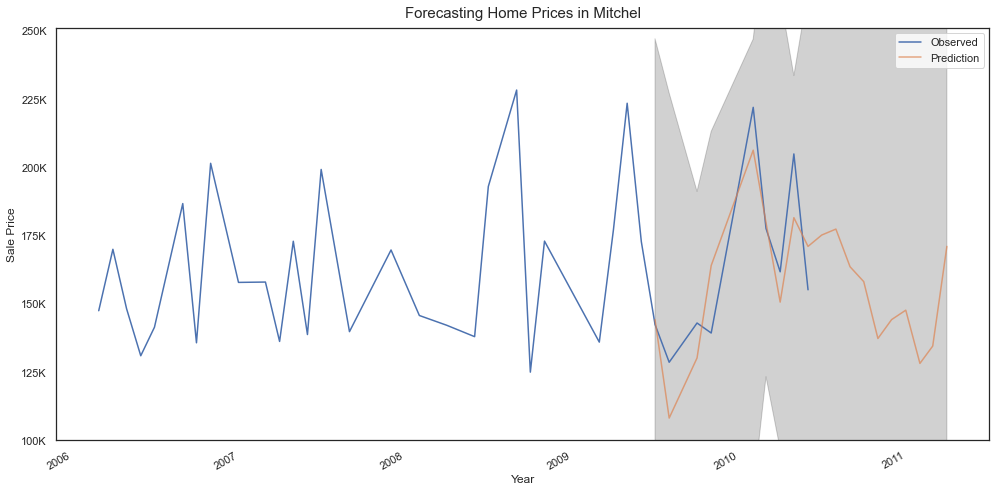

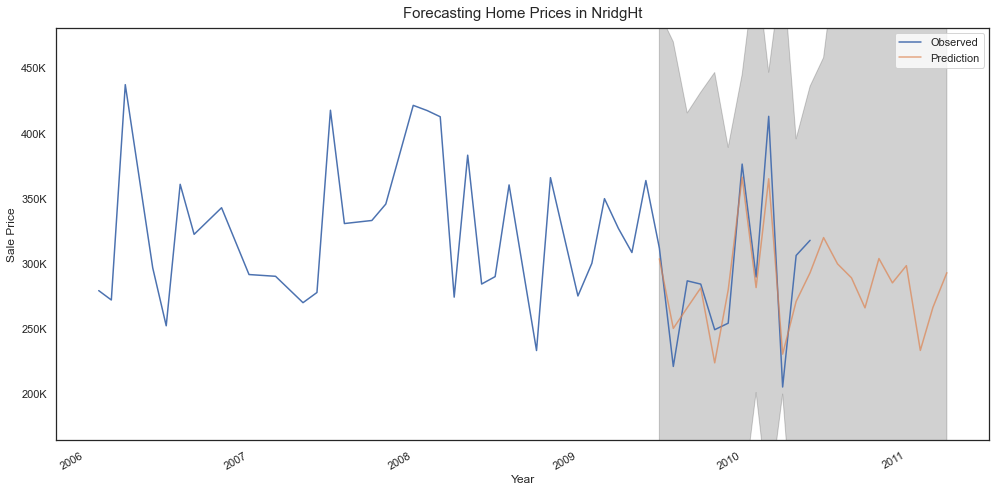

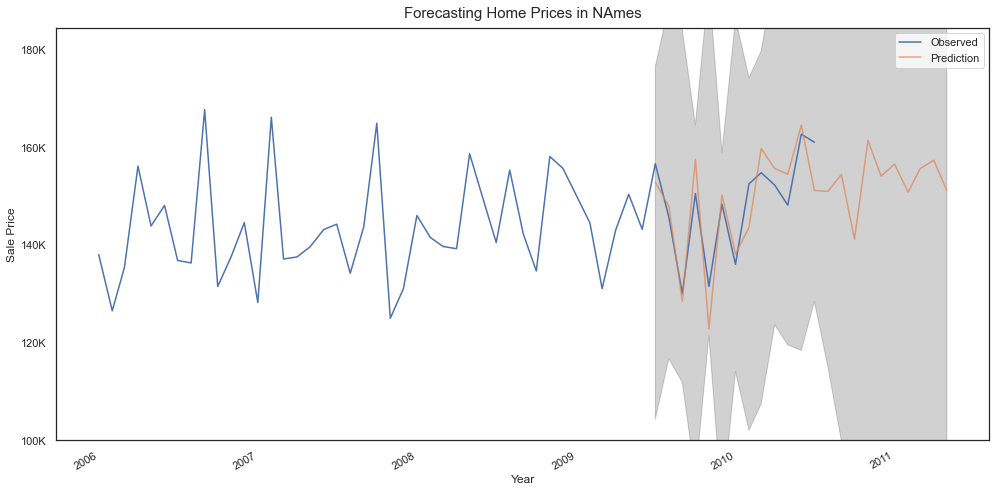

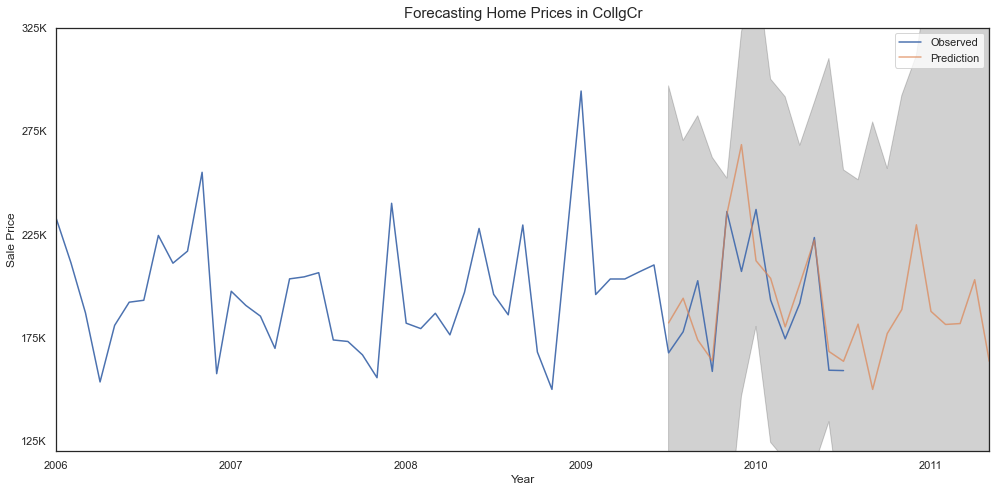

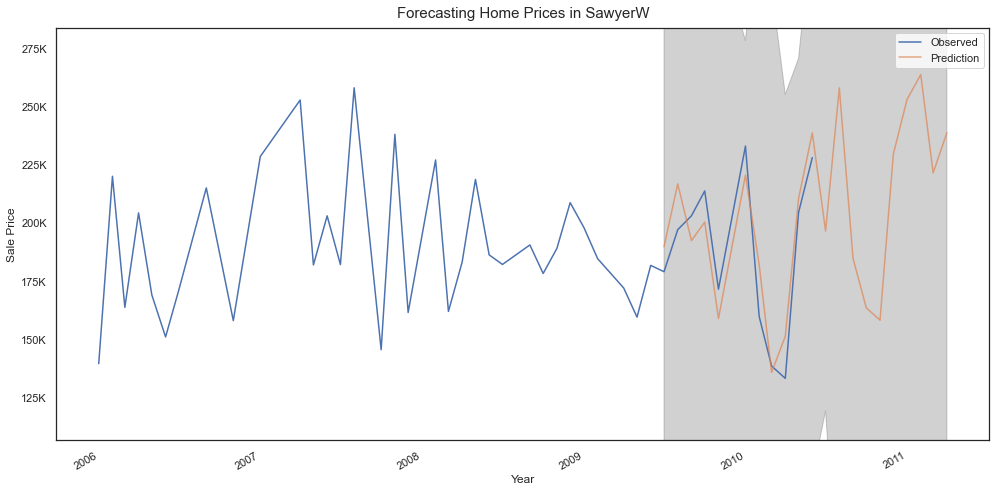

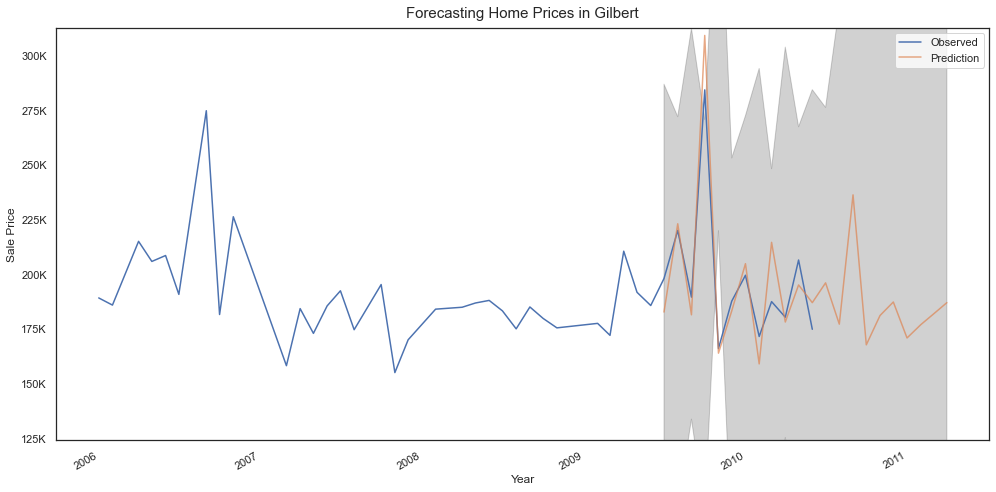

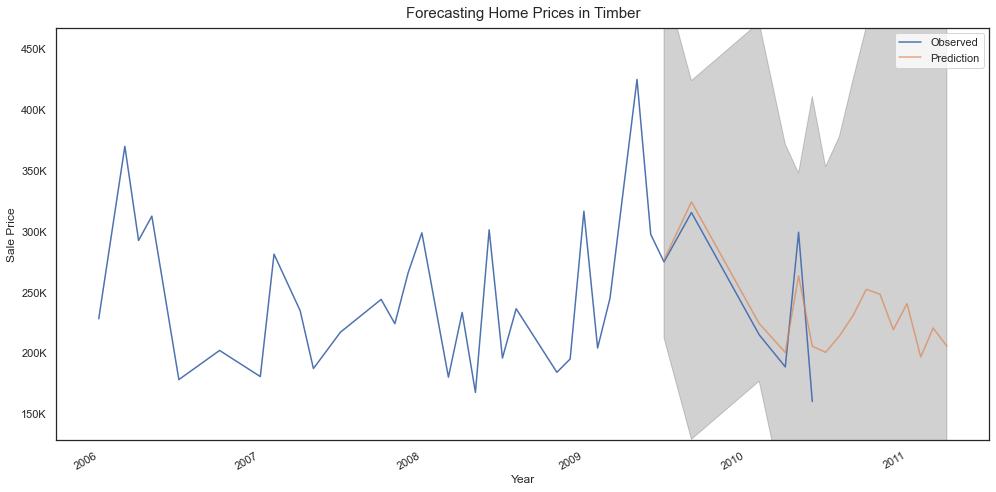

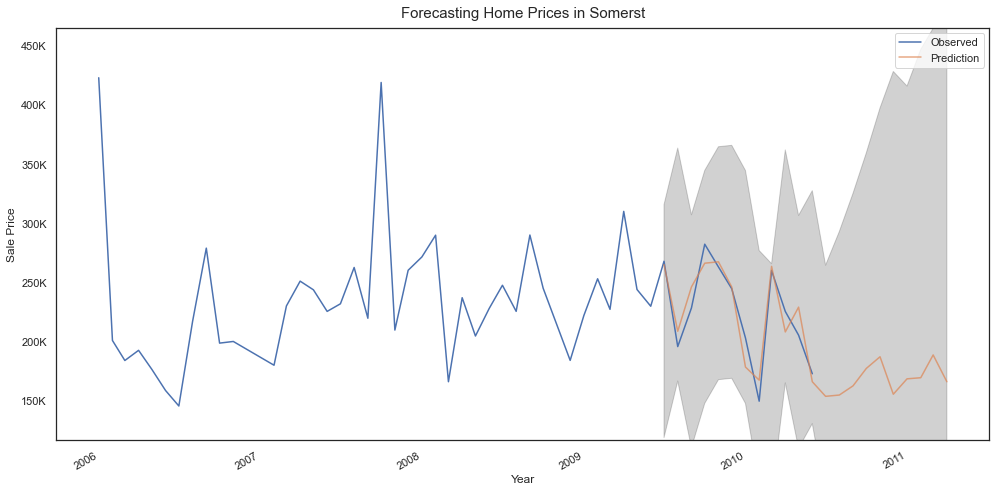

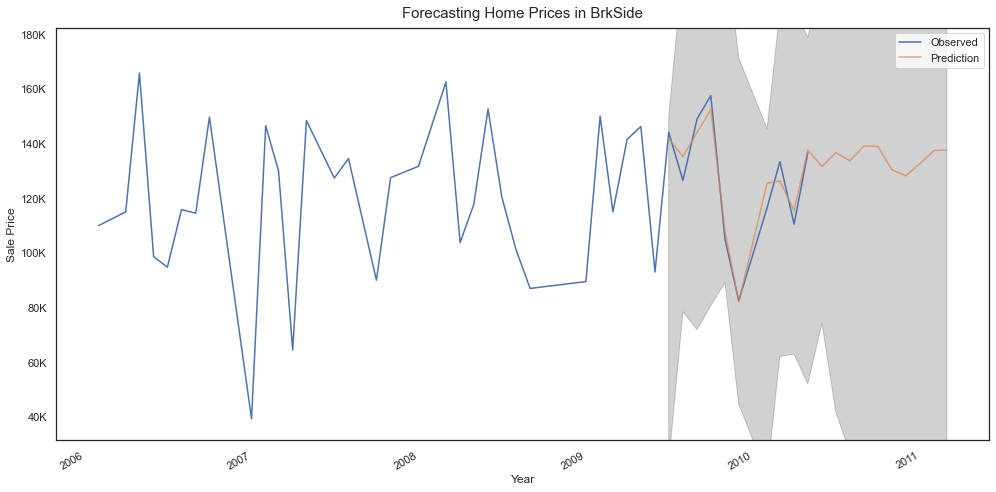

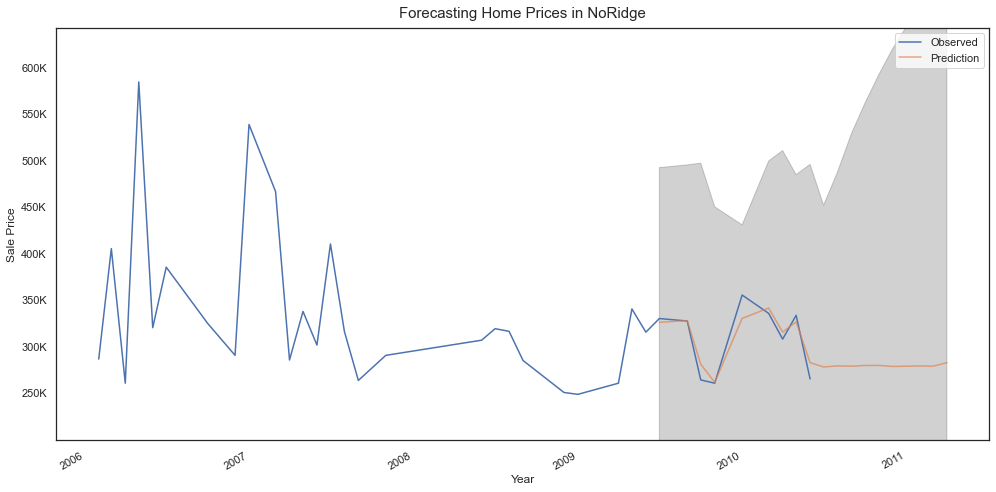

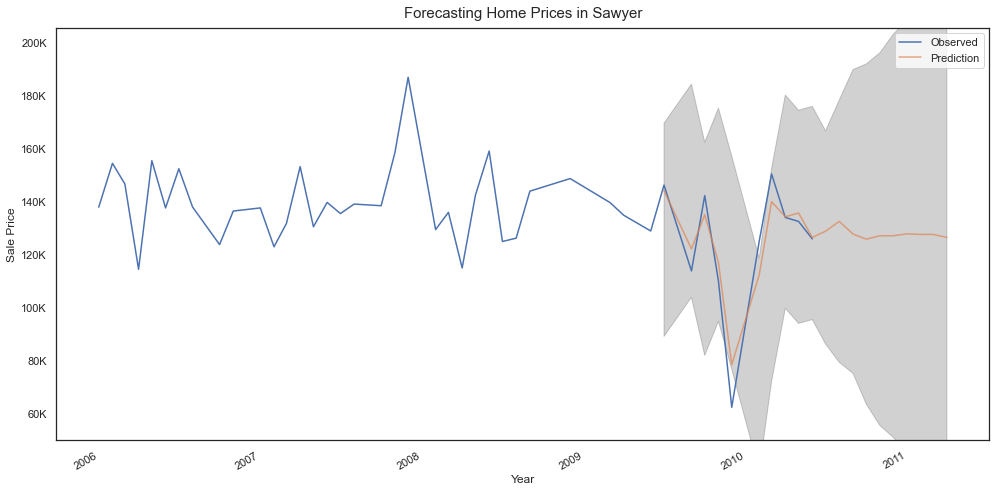

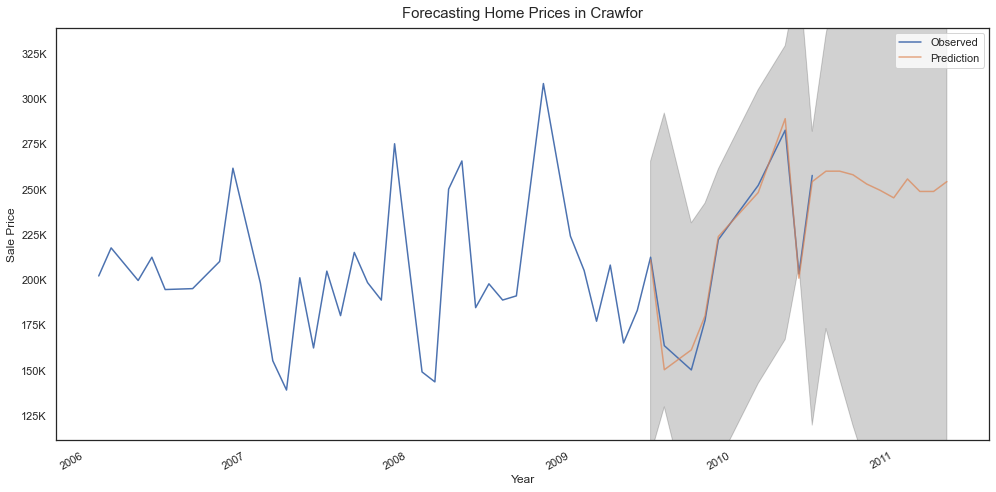

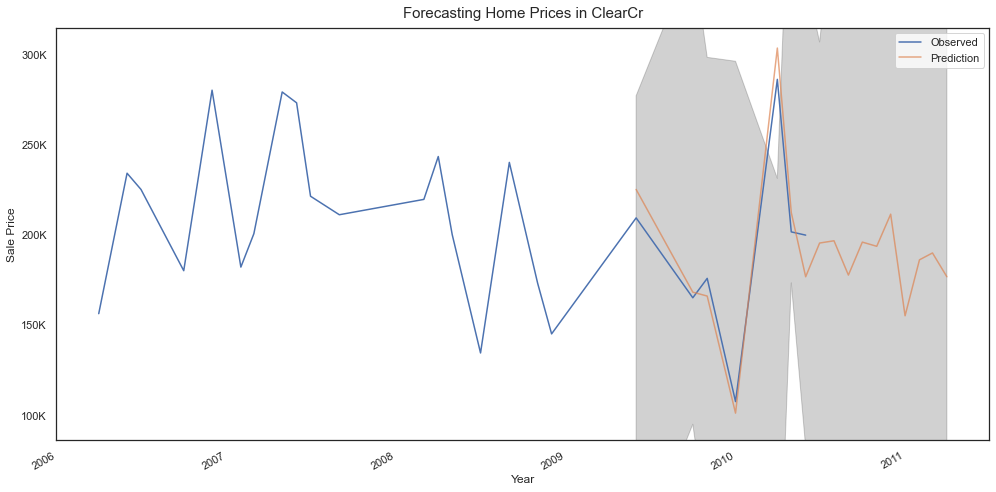

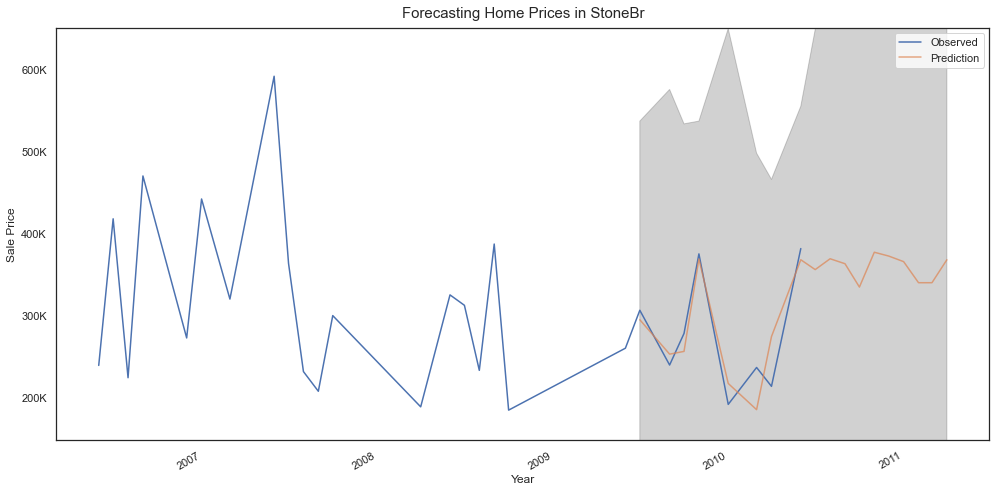

In [302]:
for neighborhood in neighborhoods:
    if neighborhood in ['Veenker', 'NPkVill', 'Blueste', 'Landmrk', 
                        'GrnHill', 'Greens', 'MeadowV', 'BrDale', 'Blmngtn']:
        pass
    else:
        housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
        housing = housing[housing['Neighborhood'] == neighborhood]
        DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                                housing['MoSold'].astype(str) + '-1').rename('DateSold')

        df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
        df.rename(columns={'SalePrice': 'Observed'}, inplace=True)


        mod = sm.tsa.statespace.SARIMAX(df,
                                        order=neighborhood_params[neighborhood][0],
                                        seasonal_order=neighborhood_params[neighborhood][1],
                                        enforce_stationarity=neighborhood_params[neighborhood][2],
                                        enforce_invertibility=neighborhood_params[neighborhood][3])
        result = mod.fit(disp=False)

        predict = result.get_prediction(start=pd.to_datetime(neighborhood_params[neighborhood][4]), dynamic=False)
        forecast = result.get_forecast(steps=10)

        forecast_dates = pd.date_range(predict.predicted_mean.index[len(predict.predicted_mean)-1], 
                          freq='MS', periods=len(forecast.predicted_mean)).shift(1)

        ci = predict.conf_int().append(forecast.conf_int().set_axis(forecast_dates))
        pred = predict.predicted_mean.append(forecast.predicted_mean.set_axis(forecast_dates))
        fig = df.plot(label='Observed')

        predicted_mean = pred.shift(-1)
        predicted_mean.iloc[len(predicted_mean)-1] = result.forecast(1)
        predicted_mean.plot(ax=fig, label='Prediction', alpha=.7, figsize=(14, 7))

        fig.fill_between(ci.index,
                        ci.iloc[:, 0],
                        ci.iloc[:, 1], color='k', alpha=.2)

        fig.set(xlabel = 'Year', ylabel = 'Sale Price',
                ylim = (min(df['Observed']) - 0.2*min(df['Observed']), 
                        max(df['Observed']) + 0.1*max(df['Observed'])),
                yticks = neighborhood_params[neighborhood][5],
                yticklabels = neighborhood_params[neighborhood][6])

        plt.title(f'Forecasting Home Prices in {neighborhood}', fontsize = 15, pad=10)
        plt.legend()
        plt.tight_layout()
#         plt.savefig(f'./visualizations/{neighborhood}_sarima_prediction.png', dpi = 600)
        plt.show()

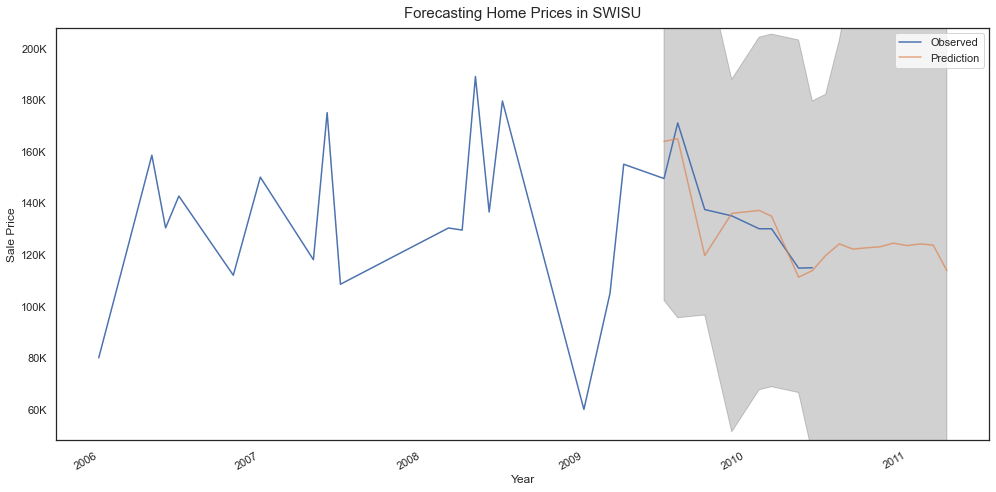

In [313]:
neighborhood = 'SWISU'

housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
housing = housing[housing['Neighborhood'] == neighborhood]
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')

df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
df.rename(columns={'SalePrice': 'Observed'}, inplace=True)


mod = sm.tsa.statespace.SARIMAX(df,
                                order=neighborhood_params[neighborhood][0],
                                seasonal_order=neighborhood_params[neighborhood][1],
                                enforce_stationarity=neighborhood_params[neighborhood][2],
                                enforce_invertibility=neighborhood_params[neighborhood][3])
result = mod.fit(disp=False)

predict = result.get_prediction(start=pd.to_datetime(neighborhood_params[neighborhood][4]), dynamic=False)
forecast = result.get_forecast(steps=10)

forecast_dates = pd.date_range(predict.predicted_mean.index[len(predict.predicted_mean)-1], 
                  freq='MS', periods=len(forecast.predicted_mean)).shift(1)

ci = predict.conf_int().append(forecast.conf_int().set_axis(forecast_dates))
pred = predict.predicted_mean.append(forecast.predicted_mean.set_axis(forecast_dates))
fig = df.plot(label='Observed')

predicted_mean = pred.shift(-1)
predicted_mean.iloc[len(predicted_mean)-1] = result.forecast(1)
predicted_mean.plot(ax=fig, label='Prediction', alpha=.7, figsize=(14, 7))

fig.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k', alpha=.2)

fig.set(xlabel = 'Year', ylabel = 'Sale Price',
        ylim = (min(df['Observed']) - 0.2*min(df['Observed']), 
                max(df['Observed']) + 0.1*max(df['Observed'])),
        yticks = neighborhood_params[neighborhood][5],
        yticklabels = neighborhood_params[neighborhood][6])

plt.title(f'Forecasting Home Prices in {neighborhood}', fontsize = 15, pad=10)
plt.legend()
plt.tight_layout()
plt.savefig(f'./visualizations/{neighborhood}_sarima_prediction.png', dpi = 600)
plt.show()